In [ ]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt

from qftools import (
    generate_uo,
    fit_uo_params,
    mle_uo_params
)

plt.style.use("ggplot")

## Definition of Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t
$$
where $W_t$ is a Wiener process, $\theta>0$ is the rate of mean reversion, $\mu$ is the mean, and $\sigma>0$ is the volatility.

### Solution to the SDE
$$
X_t = X_0 e^{-\theta t} + \mu(1 - e^{-\theta t}) + \sigma \int_0^t e^{-\theta(t-s)}dW_s
$$

### Simulation of a single path

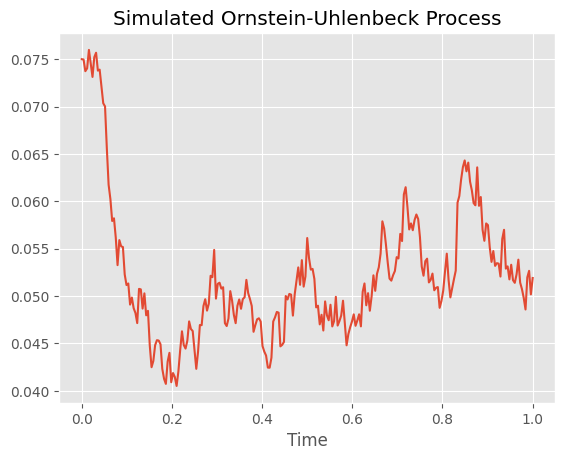

In [41]:
T = 1
N = 252 * T
mu = 0.05
sigma = 0.03
theta = 10
S_0 = 0.075

simulation = generate_uo(T, N, theta, mu, sigma, S_0, 1, random_state=42).reshape(-1)
plt.plot(np.linspace(0,T,N+1),simulation)
plt.title("Simulated Ornstein-Uhlenbeck Process")
plt.xlabel("Time")
plt.show()

## Parameters estimation
### AR(1) least squares estimation
SDE soliution for the discretisation of the Ornstein-Uhlenbeck process with fixed time increment $\Delta t$ has AR(1) form:
$$
X_t = \alpha + \beta X_{t-1} + \varepsilon_t
$$
After estimating parameters with OLS, we can write:
$$
\hat \theta = -\frac{\log(\hat\beta)}{\Delta t}
\qquad
\hat \mu = \hat\alpha/(1 - \hat\beta)
\qquad
\hat \sigma = \sqrt{\frac{\hat\sigma^2_{\varepsilon}}{1 - \hat\beta^2}}
$$
### Maximum Likelihood Estimation
The likelihood function for the Ornstein-Uhlenbeck process is given by:
$$
L(\theta, \mu, \sigma) = \prod_{i=1}^{n-1} \frac{1}{\sqrt{2\pi\sigma^2\Delta t}} \exp\left(-\frac{(X_{t_{i+1}} - X_{t_i}e^{-\theta\Delta t} - \mu(1 - e^{-\theta\Delta t}))^2}{2\sigma^2\Delta t}\right)
$$
where $\Delta t$ is the time increment.

In [52]:
theta_ols, mu_ols, sigma_ols, _ = fit_uo_params(simulation)
theta_mle, mu_mle, sigma_mle, _ = mle_uo_params(simulation, T)

theta_ols *= N/T
sigma_ols *= np.sqrt(N/T)

print (f'True theta: {theta:05.2f} True mu: {mu:05.2f} True sigma: {sigma:05.2f}')
print (f'OLS  theta: {theta_ols:05.2f} OLS  mu: {mu_ols:05.2f} OLS  sigma: {sigma_ols:05.2f}')
print (f'MLE  theta: {theta_mle:05.2f} MLE  mu: {mu_mle:05.2f} MLE  sigma: {sigma_mle:05.2f}')

True theta: 10.00 True mu: 00.05 True sigma: 00.03
OLS  theta: 13.80 OLS  mu: 00.05 OLS  sigma: 00.03
MLE  theta: 13.80 MLE  mu: 00.05 MLE  sigma: 00.03


There is very little difference between the two methods. The most challenging parameter to estimate is $\theta$. Both methods are known to have a positive bias in small samples.


## Simulation of multiple paths
Distribution of the Ornstein-Uhlenbeck process:
$$
X_t \sim N(\mu(1 - e^{-\theta t}) + X_0 e^{-\theta t}, \frac{\sigma^2}{2\theta}(1 - e^{-2\theta t}))
$$

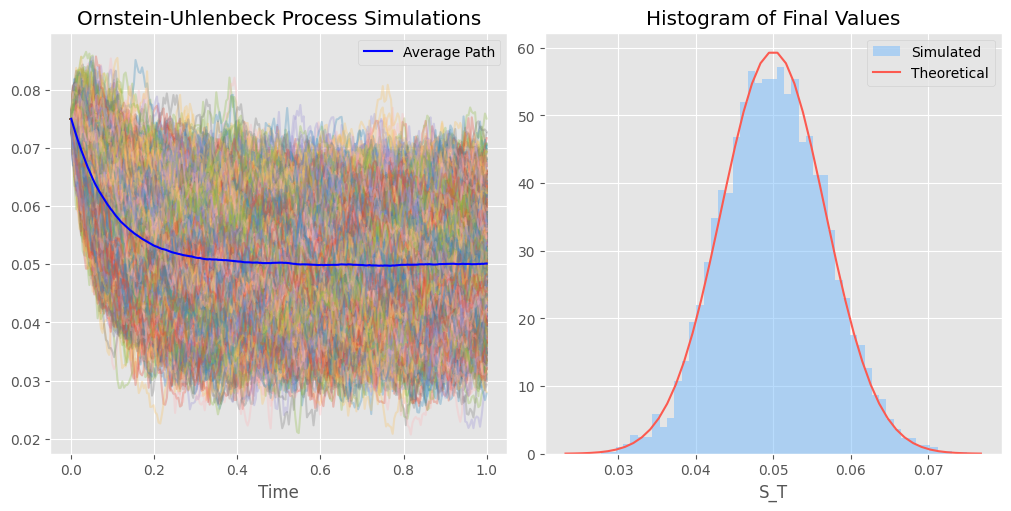

Final Values Mean:  0.0501 Std:  0.0068
Theoretical Mean:  0.0500 Std:  0.0067


In [37]:
k = 5000

theo_mean = S_0 * np.exp(-theta * T) + mu * (1 - np.exp(-theta * T))
theo_std = sigma * np.sqrt(0.5 * (1 - np.exp(-2 * theta * T)) / theta)
x = np.linspace(theo_mean - 4 * theo_std, theo_mean + 4 * theo_std)
theo_dist = scs.norm.pdf(x, theo_mean, theo_std)
simulations = generate_uo(T, N, theta, mu, sigma, S_0, k, random_state=42).T
average_path = simulations.mean(axis=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
ax[0].plot(np.linspace(0,T,N+1), simulations, alpha=0.3)
ax[0].plot(np.linspace(0,T,N+1), average_path, color='b', label='Average Path')
ax[0].set_title('Ornstein-Uhlenbeck Process Simulations')
ax[0].set_xlabel('Time')
ax[0].legend()
ax[1].hist(simulations[-1], bins=50, alpha=0.5, density=True, facecolor='xkcd:sky blue', label='Simulated')
ax[1].plot(x, theo_dist, label='Theoretical', color='xkcd:coral')
ax[1].set_title('Histogram of Final Values')
ax[1].set_xlabel('S_T')
ax[1].legend()
plt.show()

print(f'Final Values Mean: {np.mean(simulations[-1]): .4f} Std: {np.std(simulations[-1]): .4f}')
print(f'Theoretical Mean: {theo_mean: .4f} Std: {theo_std: .4f}')


## Theta estimator properties

### Distribution of the estimator

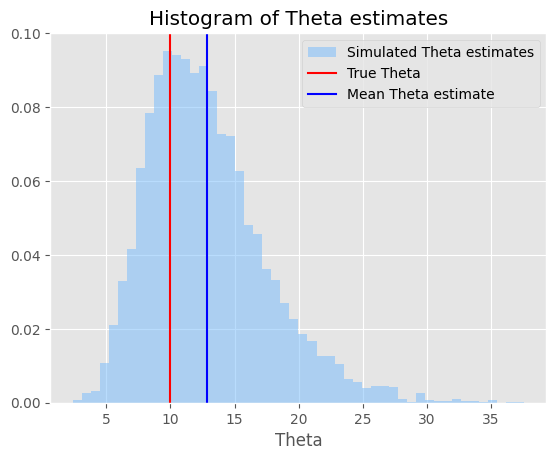

True Theta:  10.0000
Mean Theta estimate:  12.8843 Std:  4.6667


In [58]:
T = 1
N = 252 * T
simulations = generate_uo(T, N, theta, mu, sigma, S_0, k, random_state=42).T
theta_estimates = np.array([])
for i in range(k):
    theta_mle, _, _, _ = mle_uo_params(simulations[:,i], T)
    theta_estimates = np.append(theta_estimates, theta_mle)
plt.hist(theta_estimates, bins=50, alpha=0.5, density=True, facecolor='xkcd:sky blue', label='Simulated Theta estimates')
plt.axvline(theta, color='r', label='True Theta')
plt.axvline(theta_estimates.mean(), color='b', label='Mean Theta estimate')
plt.title('Histogram of Theta estimates')
plt.xlabel('Theta')
plt.legend()
plt.show()
print(f'True Theta: {theta: .4f}')
print(f'Mean Theta estimate: {theta_estimates.mean(): .4f} Std: {theta_estimates.std(): .4f}')


Increasing the time horizon should decrease the bias.

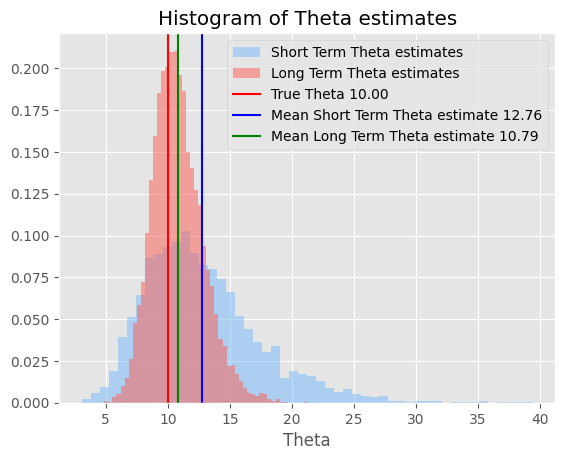

True Theta:  10.0000
Mean Short Term Theta estimate:  12.7583 Std:  4.6630
Mean Long Term Theta estimate:  10.7942 Std:  2.0436


In [59]:
k = 5000
T_short = 1
T_long = 5
N_short = 252 * T_short
N_long = 252 * T_long
simulations = generate_uo(T_long, N_long, theta, mu, sigma, S_0, k, random_state=42).T
theta_estimates_short = np.array([])
theta_estimates_long = np.array([])
for i in range(k):
    theta_mle_short, _, _, _ = mle_uo_params(simulations[:N_short,i], T_short)
    theta_mle_long, _, _, _ = mle_uo_params(simulations[:,i], T_long)
    theta_estimates_short = np.append(theta_estimates_short, theta_mle_short)
    theta_estimates_long = np.append(theta_estimates_long, theta_mle_long)
plt.hist(theta_estimates_short, bins=50, alpha=0.5, density=True, facecolor='xkcd:sky blue', label='Short Term Theta estimates')
plt.hist(theta_estimates_long, bins=50, alpha=0.5, density=True, facecolor='xkcd:coral', label='Long Term Theta estimates')
plt.axvline(theta, color='r', label=f'True Theta {theta:.2f}')
plt.axvline(theta_estimates_short.mean(), color='b', label=f'Mean Short Term Theta estimate {theta_estimates_short.mean():.2f}')
plt.axvline(theta_estimates_long.mean(), color='g', label=f'Mean Long Term Theta estimate {theta_estimates_long.mean():.2f}')
plt.title('Histogram of Theta estimates')
plt.xlabel('Theta')
plt.legend()
plt.show()
print(f'True Theta: {theta: .4f}')
print(f'Mean Short Term Theta estimate: {theta_estimates_short.mean(): .4f} Std: {theta_estimates_short.std(): .4f}')
print(f'Mean Long Term Theta estimate: {theta_estimates_long.mean(): .4f} Std: {theta_estimates_long.std(): .4f}')

Increasing the frequency on the other hand does not add much value:

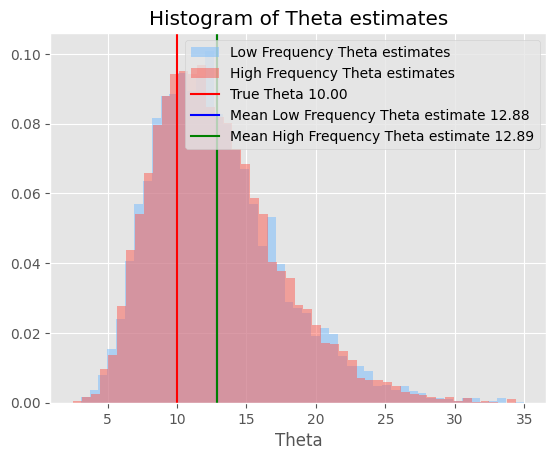

True Theta:  10.0000
Mean Low Frequency Theta estimate:  12.8844 Std:  4.6195
Mean High Frequency Theta estimate:  12.8884 Std:  4.5645


In [60]:
k = 5000
T = 1
N_low_freq = 252 * T
N_high_freq = 252 * T * 24
simulations = generate_uo(T, N_high_freq, theta, mu, sigma, S_0, k, random_state=42).T
theta_estimates_low_freq = np.array([])
theta_estimates_high_freq = np.array([])
for i in range(k):
    theta_mle_low_freq, _, _, _ = mle_uo_params(simulations[::24,i], T)
    theta_mle_high_freq, _, _, _ = mle_uo_params(simulations[:,i], T)
    theta_estimates_low_freq = np.append(theta_estimates_low_freq, theta_mle_low_freq)
    theta_estimates_high_freq = np.append(theta_estimates_high_freq, theta_mle_high_freq)
plt.hist(theta_estimates_low_freq, bins=50, alpha=0.5, density=True, facecolor='xkcd:sky blue', label='Low Frequency Theta estimates')
plt.hist(theta_estimates_high_freq, bins=50, alpha=0.5, density=True, facecolor='xkcd:coral', label='High Frequency Theta estimates')
plt.axvline(theta, color='r', label=f'True Theta {theta:.2f}')
plt.axvline(theta_estimates_low_freq.mean(), color='b', label=f'Mean Low Frequency Theta estimate {theta_estimates_low_freq.mean():.2f}')
plt.axvline(theta_estimates_high_freq.mean(), color='g', label=f'Mean High Frequency Theta estimate {theta_estimates_high_freq.mean():.2f}')
plt.title('Histogram of Theta estimates')
plt.xlabel('Theta')
plt.legend()
plt.show()
print(f'True Theta: {theta: .4f}')
print(f'Mean Low Frequency Theta estimate: {theta_estimates_low_freq.mean(): .4f} Std: {theta_estimates_low_freq.std(): .4f}')
print(f'Mean High Frequency Theta estimate: {theta_estimates_high_freq.mean(): .4f} Std: {theta_estimates_high_freq.std(): .4f}')

### Estimating the bias

Approximation of the bias from Yu (2009):
$$
E [\hat\theta] - \theta \approx \frac{1}{2 T}(3 + e^{2\theta \Delta t}) - \frac{2(1-e^{-2\theta T})}{T N (1 - e^{-2\theta \Delta t})}
$$

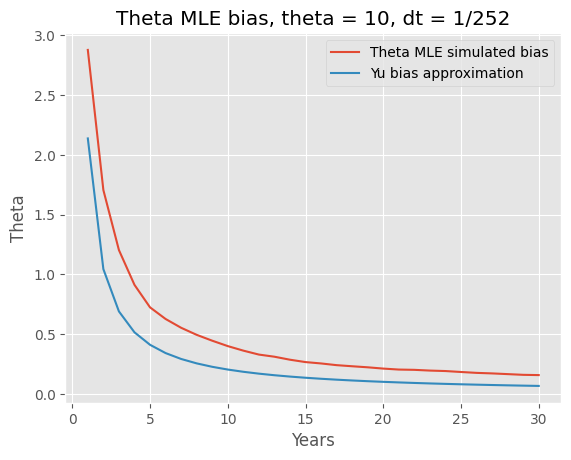

In [56]:
T = 30
N = 252 * T
simulations = generate_uo(T, N, theta, mu, sigma, S_0, k, random_state=42).T
theta_years = np.array([])
bias_approx = np.array([])
for t in range(1, T+1):
    theta_estimates = np.array([])
    n = 252 * t
    yu_bias = ((3 + np.exp(2*theta * t / n)) / (2 * t)) - \
    (2 - 2 * np.exp(-2 * theta * t))/(t * n - t * n * np.exp(2 * theta * t / n))
    for i in range(k):
        theta_mle, _, _, _ = mle_uo_params(simulations[:t*252,i], t)
        theta_estimates = np.append(theta_estimates, theta_mle)
    theta_years = np.append(theta_years, theta_estimates.mean())
    bias_approx = np.append(bias_approx, yu_bias)
yu_bias = (3 + np.exp(2*theta * T / N)) / (2 * T)
plt.plot(range(1, T+1), theta_years - theta, label='Theta MLE simulated bias')
plt.plot(range(1, T+1), bias_approx, label='Yu bias approximation')
plt.title(f'Theta MLE bias, theta = {theta}, dt = 1/252')
plt.xlabel('Years')
plt.ylabel('Theta')
plt.legend()
plt.show()